In [2]:
!nvidia-smi 
# !리눅스 terminal 명령어
#쿠다 설치하면 나옴 gpu 확인

Mon Dec  6 08:20:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pup install xxxx 
#이건 새로 열때마다 깔아줘야 함.
#새로운 컴퓨터를 배정받기 때문임

/bin/bash: pup: command not found


# Convolutional Neural Network 구현

- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [4]:
import matplotlib.pyplot as plt

# loss 그래프
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [5]:
# accuracy 그래프
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [6]:
#!pip install tensorflow==2.5.* >>2.5버전 최신버전
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [7]:
np.random.seed(0)
tf.random.set_seed(0)

##### data loading

In [8]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

#(60000,28,28) - (개수, h, w) #지금은 흑백이라서 이렇게 나오는데 >> channel 축이 없음
#근데 cnn 넣을때는 (30000,28,28,1) 잡아줘야 함.


11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

##### 하이퍼파라미터, 변수 설정

In [9]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_image.shape[0] #60000
N_TEST = test_image.shape[0] #10000

##### 전처리, Dataset 생성
- X: 0 ~ 1 scaling
    - gray scale 일 경우 channel 축을 늘려줘야 한다. (h, w, 1)
- Y: onehot encoding

In [10]:
# X: 0 ~ 1 scaling
X_train_tmp = (train_image/255.0).astype(np.float32)
X_test_tmp = (test_image/255.0).astype(np.float32)
print(X_train_tmp.shape, X_test_tmp.shape)
# channel 축을 추가
X_train = X_train_tmp[..., np.newaxis] #...: 원래 shape, np.newaxis는 크기가 1인 axis 추가
X_test = X_test_tmp[..., np.newaxis]
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [11]:
# y: onehot-encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

###### Dataset 생성

In [12]:
#colab에서 자동완성은 ctrl+space
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [13]:
def create_mnist_model():
    model = keras.Sequential()

    model.add(layers.InputLayer((28, 28, 1))) #Conv2D의 input은 반드시 3차원(h, w, channel)

    model.add(layers.Conv2D(filters=32, #Filter 개수
                            kernel_size=(3,3), #Filter Size(h, w)
                            padding='same', #padding:방식: same-input size와 output(Feature map) size 가 동일하게 나오도록 zero padding 추가, "valid"-padding사용 안함.(기본값))
                            strides=(1,1), #conv 연산시 이동 보폭 (좌우, 상하) 기본: (1,1)
                            activation='relu' # conv연산 결과를 넣어줄 활성함수
                            ))
    
    model.add(layers.MaxPool2D(pool_size=(2,2), #(2,2) 영역에서 가장큰 값 하나 추출
                               strides=(2,2), #이동 보폭. 기본값=None: pool_size의 설정과 동일한 크기
                               padding='same')) #기본: valid - 나머지 자투리영역은 버림.
                                                #same - 자투리 영역에서도 가장 큰 값 추출

    model.add(layers.Conv2D(filters=64, #필터 개수는 늘려나간다.
                            kernel_size=3, #(3,3) // (h,w) - h/w의 크기가 같은 경우 값 하나만 지정(풀링에서도 동일)     
                            padding='same',
                            activation='relu'
                            ))
    model.add(layers.MaxPool2D(padding='same')) #pool_size-(2,2)/stride(None)는 기본 사용
                                                #padding-기본(valid)  
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))
    #conv2d와 pooling layer를 합쳐서 블록이라고 함
    
    #출력 feature map 하나의 shape =>>3차원 (h, w, c) 
    model.add(layers.Flatten()) #3차원을 1차원으로

    #Dense layer의 입력의 shape -> 1차원
    model.add(layers.Dense(units=256, activation='relu')) #hidden layer에 Dense 레이어 추가

    #출력 layer-class 개수: 10, 다중분류-activation=softmax
    model.add(layers.Dense(units=10, activation='softmax'))

    return model

##### 컴파일

In [14]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [16]:
#conv 파라미터 개수
#filter_width (filter_height * input_channel) * filter 개수 + bias(filter 개수)

#1번 conv레이어의 파라미터 개수
print(3*3*1*32+32)
#2번 conv 레이어의 파라미터 개수
print(3*3*32*64+64)

320
18496


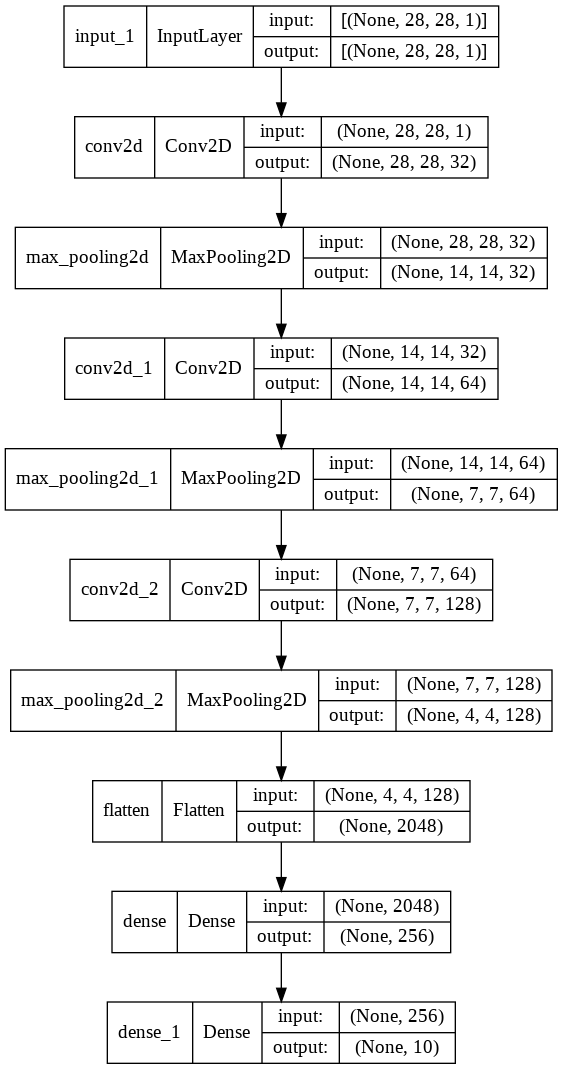

In [17]:
keras.utils.plot_model(model, show_shapes=True)

#64개의 특징을 찾음
#pooling은 크기가 작아짐
#conv에서는 채널이 늘어남



##### 학습

In [18]:
hist = model.fit(train_dataset, 
                 epochs=N_EPOCHS, 
                 validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 22s 15ms/step - loss: 0.1620 - accuracy: 0.9504 - val_loss: 0.0416 - val_accuracy: 0.9859
Epoch 2/20
600/600 [==============================] - 8s 14ms/step - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0443 - val_accuracy: 0.9853
Epoch 3/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0308 - accuracy: 0.9905 - val_loss: 0.0330 - val_accuracy: 0.9881
Epoch 4/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0235 - accuracy: 0.9923 - val_loss: 0.0252 - val_accuracy: 0.9915
Epoch 5/20
600/600 [==============================] - 8s 14ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0239 - val_accuracy: 0.9926
Epoch 6/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.0196 - val_accuracy: 0.9930
Epoch 7/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.0280 - val_accuracy: 0.991

##### 결과시각화

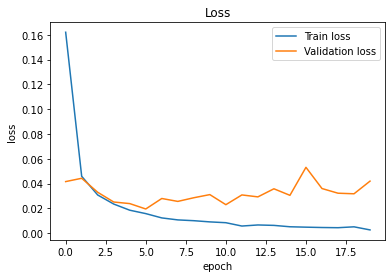

In [19]:
plot_loss(hist)

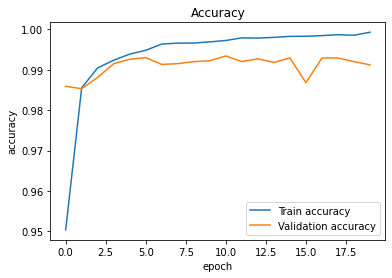

In [20]:
plot_accuracy(hist)

##### 최종검증

In [21]:
loss, acc = model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9912


In [22]:
print(loss, acc)

0.042020283639431 0.9911999702453613


## prediction error가 발생한 example 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [23]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [24]:
pred[:5, :4] #행을 기준으로 가장 큰 값을 뽑아냄

array([[3.2876310e-21, 3.6884643e-15, 3.5763893e-21, 2.3054067e-14],
       [5.1460131e-14, 1.2753008e-17, 1.0000000e+00, 7.5484276e-23],
       [4.9486766e-13, 1.0000000e+00, 1.6696201e-15, 5.9893576e-18],
       [1.0000000e+00, 2.9026179e-22, 1.4680489e-22, 3.3732736e-18],
       [9.0500143e-15, 3.4214664e-13, 1.3308218e-16, 2.2891364e-15]],
      dtype=float32)

In [25]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [26]:
#test_label(정답) 와 pred_label(추론) 간에 틀린 것의 index 조회
idx = np.where(test_label != pred_label)[0]
idx.shape #10000개 중에 80개 틀림

(88,)

In [27]:
idx[:10]
#92번째 175번째......726번째 틀림

array([ 18, 115, 175, 321, 340, 445, 448, 449, 582, 659])

##### confusion matrix 확인

In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(test_label, pred_label)

#x축 추론, y축 정답
#대각선에 있는것들 빼고 나머지는 다 틀렸다는 거임

array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   3, 1132,    0,    0,    0,    0,    0,    0,    0,    0],
       [   4,    1, 1022,    0,    0,    0,    0,    3,    2,    0],
       [   0,    0,    0, 1005,    0,    3,    0,    0,    2,    0],
       [   0,    0,    0,    0,  972,    0,    0,    1,    1,    8],
       [   2,    0,    0,    5,    0,  880,    0,    0,    5,    0],
       [  10,    3,    1,    0,    2,    1,  938,    0,    3,    0],
       [   0,    3,    1,    0,    0,    0,    0, 1020,    1,    3],
       [   2,    0,    1,    0,    0,    0,    0,    0,  970,    1],
       [   0,    0,    0,    0,    3,    5,    0,    3,    3,  995]])

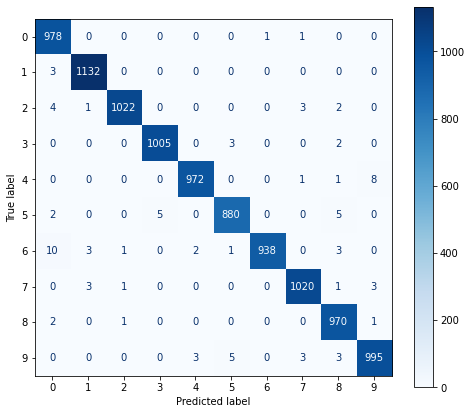

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = plt.gca()

cm = confusion_matrix(test_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.show()

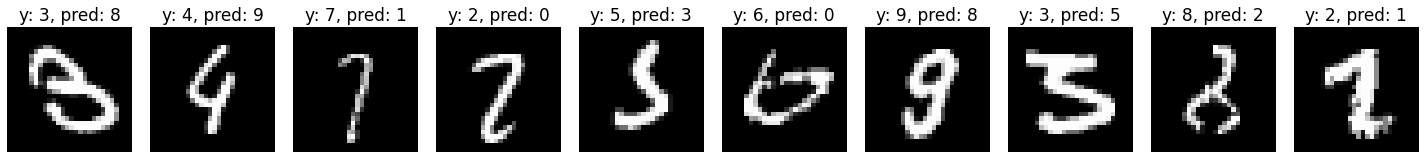

In [30]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

for i in range(10):  
   
    error_idx = idx[i]
    
    p = pred_label[error_idx] #추론 결과들
    y = test_label[error_idx] #정답들

    plt.subplot(1, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title("y: {}, pred: {}".format(y, p), fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 학습한 모델 파일로 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

### Checkpoint 으로 저장

##### 저장할 경로 생성및 저장

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os

base_dir = "/content/drive/MyDrive/saved_models"

if not os.path.isdir(base_dir): #base_dir이 있는 디렉토리인지?
    os.mkdir(base_dir) #디렉토리가 없으면 만들어라

mnist_weight_dir = os.path.join(base_dir, "mnist_weight") #모델의 weight들을 저장할 디렉토리명
print(mnist_weight_dir)

if not os.path.isdir(mnist_weight_dir):
    os.mkdir(mnist_weight_dir)
    
    #저장할 weight 파일명
weight_file_path = os.path.join(mnist_weight_dir, "mnist_weight_ckpt")

print(weight_file_path)

/content/drive/MyDrive/saved_models/mnist_weight
/content/drive/MyDrive/saved_models/mnist_weight/mnist_weight_ckpt


In [34]:
#모델 저장
model.save_weights(weight_file_path) #parameter들만 저장

In [35]:
#loading시에는 먼저 모델 네트워크 구조부터 생성
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [36]:
new_model.evaluate(test_dataset)
#정확도가 9%로 학습이 하나도 안된 모델

100/100 [==============================] - 1s 7ms/step - loss: 2.3066 - accuracy: 0.0980


[2.306602716445923, 0.09799999743700027]

In [37]:
#new 모델에 학습된(저장된) parameter들을 읽어와서 덮어써줌
#저장했던 weight를 덮어씀
new_model.load_weights(weight_file_path)

In [39]:
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9912


[0.042020283639431, 0.9911999702453613]

### h5 형식으로 저장

In [40]:
weight_h5_dir = os.path.join(base_dir, "mnist_weight_h5")
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir, exist_ok=True)
weight_h5_path = os.path.join(weight_h5_dir, "mnist_weight.h5")

In [42]:
weight_h5_path

'/content/drive/MyDrive/saved_models/mnist_weight_h5/mnist_weight.h5'

In [43]:
#포맷에 맞춰 저장
model.save_weights(weight_h5_path, save_format='h5')

In [44]:
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [45]:
new_model.evaluate(test_dataset)
#학습안한 상태에서 모델 평가

100/100 [==============================] - 1s 7ms/step - loss: 2.3001 - accuracy: 0.0936


[2.3000831604003906, 0.09359999746084213]

In [46]:
#new_model에 저장된 weights(파라미터)를 덮어씀
new_model.load_weights(weight_h5_path)

In [47]:
# weights 덮어쓴 후 평가
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9912


[0.042020283639431, 0.9911999702453613]

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

###  Saved Model 형식으로 모델 저장
- 경로(디렉토리) 만 지정한다.

In [48]:
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
print(mnist_model_dir, type(mnist_model_dir))
if not os.path.isdir(mnist_model_dir):
    os.mkdir(mnist_model_dir) 

/content/drive/MyDrive/saved_models/mnist_model <class 'str'>


In [51]:
new_model2 = keras.models.load_model(mnist_model_dir) #저장된 모델구조+파라미터

In [49]:
#weight+모델구조 저장: saved_model 형식으로 저장(기본)=> 저장할 디렉토리만 지정.
model.save(mnist_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/mnist_model/assets


In [52]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9912


[0.042020283639431, 0.9911999702453613]

### H5 형식으로 모델 저장

In [53]:
model_h5_dir = os.path.join(base_dir, 'mnist_model_h5')

if not os.path.join(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)

model_h5_path = os.path.join(model_h5_dir, "mnist_model.h5") #h5 형식 저장시 파일명까지 지정

In [54]:
model.save(model_h5_path, save_format='h5') #확장자가 h5라면 save_format 생략가능

In [55]:
new_model3 = keras.models.load_model(model_h5_path)

new_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [56]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9912


[0.042020283639431, 0.9911999702453613]

In [ ]:
#구글 드라이브에 외부 저장소를 붙이는 것은 마운트를 해야 가능
#외부 저장소(구글드라이브)에 저장하거나 읽을때 사용

In [ ]:
#이전에 다른 모델의 weight를 가져와서 덮어쓰는데 모델의 구조가 같아야함 
#이전것과 지금것의 구조가 같아야 함.!

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [ ]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [ ]:
model2.evaluate(test_dataset)

In [ ]:
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback')
if not os.path.isdir(checkpoint_save_dir):
    os.mkdir(checkpoint_save_dir)

checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt')

In [ ]:
mc_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_file, 
                          save_best_only=True, 
                          monitor='val_loss',  
                          verbose=1)

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5
                                            verbose=1)

In [ ]:
hist = model2.fit(train_dataset, epochs=5, validation_data=test_dataset,
                  callbacks=[mc_callback, es_callback])

In [ ]:
new_model3 = keras.models.load_model(checkpoint_save_file)

In [ ]:
new_model3.evaluate(test_dataset)